# Avocado Sales Dataset

In [117]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
dataset_name = "avocado_sales"

In [119]:
input_fname = "avocado.csv"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [120]:
data = pd.read_csv(input_fname)
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


# Process Data

In [121]:
data.columns

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')

In [122]:
# Remove "Unnamed: 0" column 
del data["Unnamed: 0"]

# Remove region called 'WestTexNewMexico'. it has 3 less data points.
data = data[data['region'] != 'WestTexNewMexico']

# Process Date column 
data['Date'] = pd.to_datetime(data['Date'])

In [123]:
# use snake_case for field names for naming consistency
data.rename(columns={
    "Date": "date", 
    "AveragePrice": "average_sales_price",
    "Total Volume": "total_bulk_and_bagged_units", 
    "4046": "plu_4046_units",
    "4225": "plu_4225_units",
    "4770": "plu_4770_units",
    "Total Bags": "total_bagged_units",
    "Small Bags": "small_bagged_units",
    "Large Bags": "large_bagged_units",
    "XLarge Bags": "xlarge_bagged_units",    
}, inplace=True)

In [124]:
# Create a unique series for each combination of `region` and `type`
data["series_id"] = data.apply(lambda row: row["region"] + "_" + row["type"], axis=1)

In [125]:
# Create a binary variable called "is_organic". We will use it as an exogenous variable 
data["is_organic"] = data["type"].map({
    "conventional": 0,
    "organic": 1
})

In [126]:
# Sort data
data.sort_values(by=['series_id', 'date'], inplace=True)

In [127]:
# remove unwanted columns 
data.drop(columns=['total_bagged_units', 'region', 'year'], inplace=True)

In [128]:
# Convert units to thousands
cols = [
    'total_bulk_and_bagged_units',
    'plu_4046_units', 'plu_4225_units', 'plu_4770_units',
    'small_bagged_units', 'large_bagged_units', 'xlarge_bagged_units'
]
data[cols] = data[cols] / 1000.

In [129]:
data.columns

Index(['date', 'average_sales_price', 'total_bulk_and_bagged_units',
       'plu_4046_units', 'plu_4225_units', 'plu_4770_units',
       'small_bagged_units', 'large_bagged_units', 'xlarge_bagged_units',
       'type', 'series_id', 'is_organic'],
      dtype='object')

In [130]:
series_col = "series_id"
epoch_col = 'date'
time_col = 'date'
value_col = 'total_bulk_and_bagged_units'
exog_cols=[
    'average_sales_price', 
    'plu_4046_units', 'plu_4225_units', 'plu_4770_units',
    'small_bagged_units', 'large_bagged_units', 'xlarge_bagged_units', 
    'is_organic'
]

# Visualize

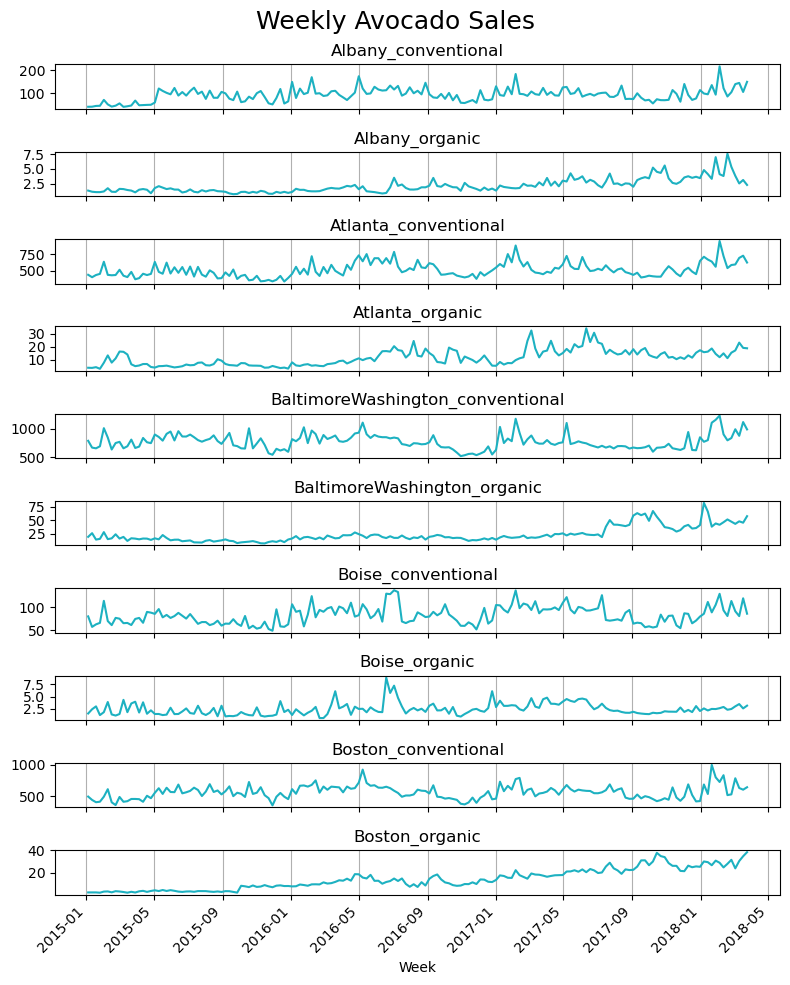

In [131]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=time_col,
    epoch_label='Week',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="Weekly Avocado Sales"
)

# Save Data

In [136]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols

data = data[all_cols]
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False, float_format="%.3f")

In [133]:
data.shape

(17914, 11)

In [134]:
data.head()

,series_id,date,total_bulk_and_bagged_units,average_sales_price,plu_4046_units,plu_4225_units,plu_4770_units,small_bagged_units,large_bagged_units,xlarge_bagged_units,is_organic
51,Albany_conventional,2015-01-04,40.87328,1.22,2.81950,28.28742,0.04990,9.18693,0.52953,0.0,0
50,Albany_conventional,2015-01-11,41.19508,1.24,1.00285,31.64034,0.12712,8.03604,0.38873,0.0,0
49,Albany_conventional,2015-01-18,44.51128,1.17,0.91414,31.54032,0.13577,11.65109,0.26996,0.0,0
48,Albany_conventional,2015-01-25,45.14750,1.06,0.94138,33.19616,0.16414,10.10335,0.74247,0.0,0
47,Albany_conventional,2015-02-01,70.87360,0.99,1.35390,60.01720,0.17932,9.17082,0.15236,0.0,0


In [135]:
data.describe()

,date,total_bulk_and_bagged_units,average_sales_price,plu_4046_units,plu_4225_units,plu_4770_units,small_bagged_units,large_bagged_units,xlarge_bagged_units,is_organic
count,17914,17914.000000,17914.000000,17914.000000,17914.000000,17914.000000,17914.000000,17914.000000,17914.000000,17914.000000
mean,2016-08-14 00:00:00,858.483909,1.408676,293.794426,299.436042,23.101087,184.489175,54.514041,3.147017,0.500000
min,2015-01-04 00:00:00,0.084560,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-10-25 00:00:00,10.744483,1.100000,0.821848,2.962188,0.000000,2.792165,0.125625,0.000000,0.000000
50%,2016-08-14 00:00:00,107.330165,1.370000,8.640940,29.055720,0.183000,26.340005,2.637090,0.000000,0.500000
75%,2017-06-04 00:00:00,421.199603,1.660000,107.955493,152.315503,6.025527,82.741915,21.552535,0.137458,1.000000
max,2018-03-25 00:00:00,62505.646520,3.250000,22743.616170,20470.572610,2546.439110,13384.586800,5719.096610,551.693650,1.000000
std,NaN,3484.713974,0.400221,1276.251634,1214.875380,108.434976,752.891317,246.057779,17.847595,0.500014
